# 大黒海釣り施設、アジ釣果分析その１

## モジュールのインポート

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [10, 6]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [11]:
# 大黒、アジに絞ってSQLite3データベースを検索

conn = sqlite3.connect("../data/fishing_result.db")
sql = '''
select
    r.Date,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species = 'アジ'
    and r.Point = 'daikoku'
    and r.Date > '2018-01-01'
'''
df=pd.read_sql_query(sql, conn)
df.head()

,Date,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
0,2018-02-18,アジ,3,22.0,23.0,10.0,119.0
1,2018-02-20,アジ,4,23.0,25.0,10.0,56.0
2,2018-02-21,アジ,2,19.0,21.0,10.3,44.0
3,2018-02-23,アジ,3,22.0,24.0,10.5,31.0
4,2018-02-26,アジ,4,22.0,23.0,10.5,36.0


In [12]:
# 土日祝日化判定列を追加

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

In [13]:
# 日付を索引にセットし、年、月カラムを追加

df = df.set_index('Date')
df['Year'] = df.index.year
df['Month'] = df.index.month

## 平日、休日の入場者数比較

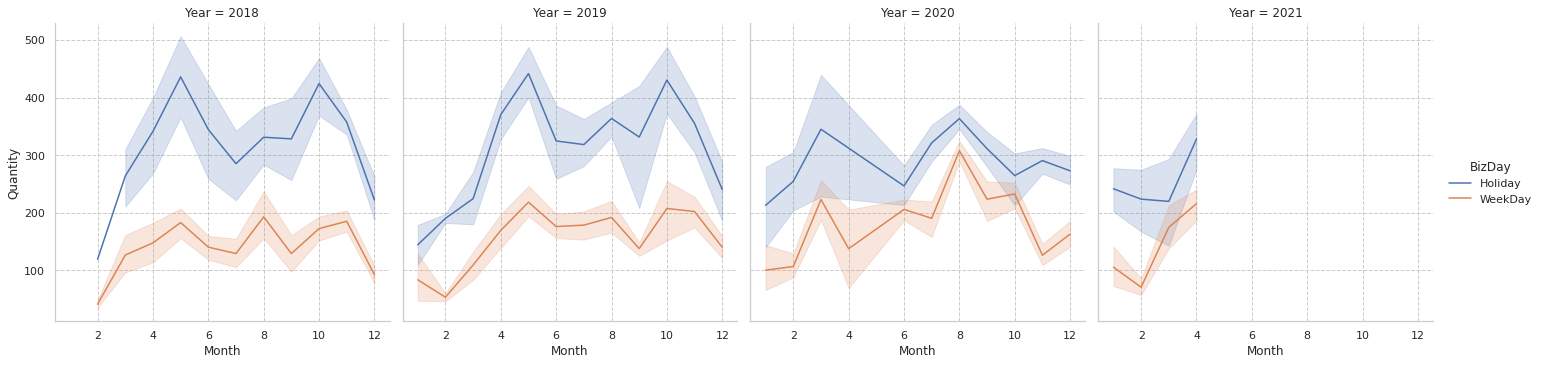

In [16]:
# 平日、休日の入場者数の比較

sns.relplot(x='Month', y='Quantity', hue='BizDay',data=df, col='Year', kind="line")

# アジの釣果サイズの比較

In [17]:
# seaborn でプロットしやすいようにデータフレームを横縦変換する

df2 = df[['Count', 'SizeMin', 'SizeMax','WaterTemp', 'Quantity']]
df2 = df2.stack().reset_index()
df2 = df2.rename(columns={'level_1': 'Metric', 0: 'Value'})

# 平日、休日判定列を追加

df2['BizDay'] = df2.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセットして、各年月日列を追加

df3 = df2.set_index('Date')
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['DayOfYear'] = df3.index.dayofyear
df3['WeekOfYear'] = df3.index.strftime('%U').astype(int) # df3.index.week
df3.head()

,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2018-02-18,Count,3.0,Holiday,2018,2,49,7
2018-02-18,SizeMin,22.0,Holiday,2018,2,49,7
2018-02-18,SizeMax,23.0,Holiday,2018,2,49,7
2018-02-18,WaterTemp,10.0,Holiday,2018,2,49,7
2018-02-18,Quantity,119.0,Holiday,2018,2,49,7


## アジの釣果サイズの比較

<AxesSubplot:xlabel='Metric', ylabel='Value'>

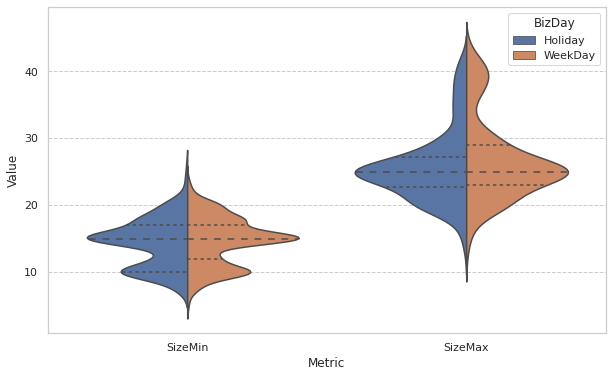

In [18]:
# アジの最小、最大サイズに絞り込んで平日、休日の分布図を比較

df4 = df3.loc[df3['Metric'].isin(['SizeMax', 'SizeMin'])]
sns.violinplot(data = df4, x="Metric", y="Value", hue="BizDay", split=True, inner="quart")

<AxesSubplot:xlabel='Month', ylabel='Value'>

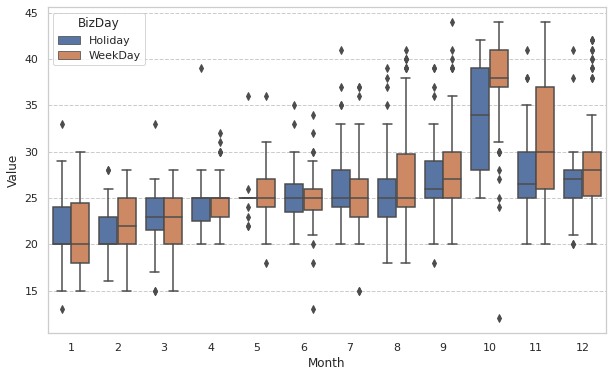

In [19]:
# 月別のアジ最大サイズの分析

df5 = df3.loc[df3['Metric'].isin(['SizeMax'])]
sns.boxplot(data = df5, x="Month", y="Value", hue="BizDay")

# 海水温の比較

<AxesSubplot:xlabel='Month', ylabel='Value'>

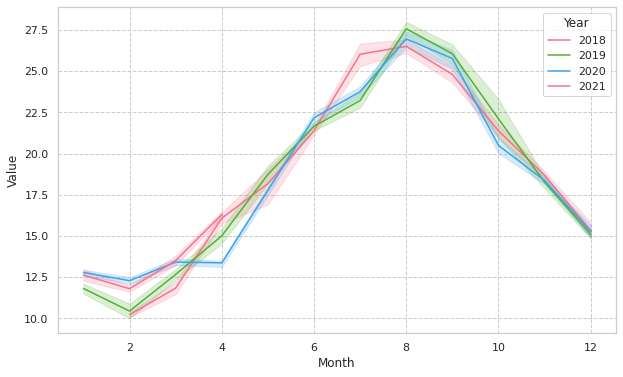

In [31]:
# 海水温
sns.lineplot(data=df3.query('Metric == "WaterTemp"'), x='Month', y='Value', hue='Year',
            palette="husl")

## 年度別のアジ釣果分析

<AxesSubplot:xlabel='Month', ylabel='Value'>

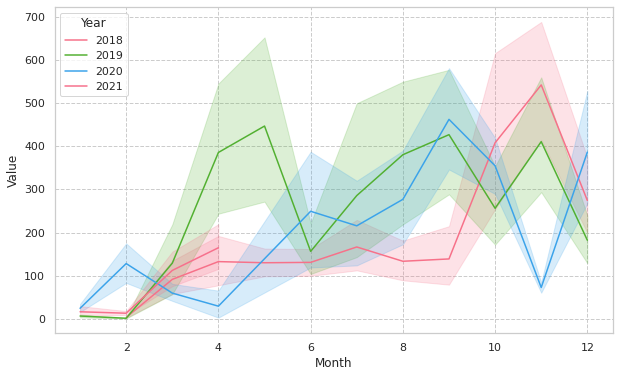

In [32]:
# 平日の釣果に絞り込む
df7 = df3.query('BizDay == "WeekDay"')

# 年度別アジ釣果数の比較
sns.lineplot(data=df7.query('Metric == "Count"'), x='Month', y='Value', hue='Year',
            palette="husl")

<AxesSubplot:xlabel='Month', ylabel='Value'>

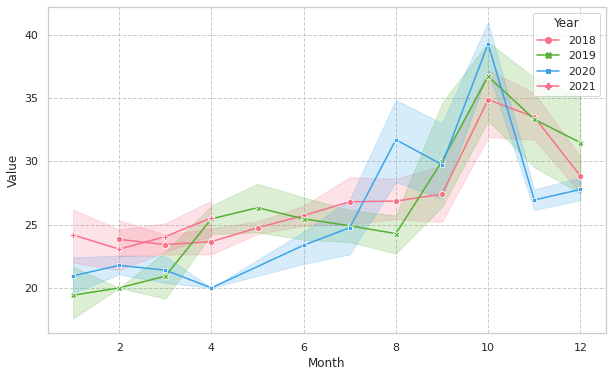

In [33]:
# 大黒海釣り施設のアジ釣果サイズ(最大)の比較

df10 = df7.loc[df7['Metric'].isin(['SizeMax'])]
sns.lineplot(data=df10, x='Month', y='Value', hue='Year', style='Year',
            markers=True, dashes=False, palette="husl")